# Source Reconstruction
1. FreeSurfer MRI reconstruction


In [19]:
# Setup and imports
import os.path as op
import re
from pathlib import Path

import matplotlib.pyplot as plt
import mne
import mne_connectivity
import numpy as np
from IPython.display import clear_output
from mne_connectivity import envelope_correlation
from tqdm.auto import tqdm


In [ ]:

# Helper functions
def insert_fcz_pos(epochs):
    '''
    add FCz position based on channels CPz
    (Their positions are the same, only y-axis value is different)
    '''
    import copy
    ch_names = copy.deepcopy(epochs.info['ch_names']) 
    [ch_names.remove(i) for i in ['ECG', 'EOG1', 'EOG2']]
    pos_array = epochs._get_channel_positions()
    
    pos_fcz = pos_array[ch_names.index('CPz')] * np.array([1, -1, 1])
    pos_array = np.insert(pos_array, 58, pos_fcz, axis=0)
    pos_array = np.delete(pos_array, -1, axis=0)
    
    pos_dict = dict(zip(ch_names, pos_array))
    pos = mne.channels.make_dig_montage(pos_dict)
    
    return pos

def _make_montage(path='../../data/raw/plb-hyp-live2131111.vhdr'):
    """
    Create a montage from barin vision raw data

    Parameters
    ----------
    path : str
        path to barinvision data header file

    """
    import copy
    raw = mne.io.read_raw_brainvision(path, verbose=False, misc=['ECG'])
    raw.crop(1, 10)  # crop a small segment of the data to speed up data loading in next lines
    raw.load_data().set_channel_types({'ECG': 'ecg'})
    # raw.add_reference_channels('FCz')  # FCz was used as online reference
    ch_names = copy.deepcopy(raw.info['ch_names'])  # make a deep copy of the lists of the
    # channel names otherwise ecg channel will be removed in the raw object!!
    ch_names.remove('ECG')

    pos_array = raw._get_channel_positions()

    # # add FCz position based on channels CPz (Their positions are the same, only y-axis value is different)
    # pos_fcz = pos_array[ch_names.index('CPz')] * np.array([1, -1, 1])
    # pos_array = np.insert(pos_array, 60, pos_fcz, axis=0)
    # pos_array = np.delete(pos_array, -1, axis=0)

    pos_dict = dict(zip(ch_names, pos_array))
    pos = mne.channels.make_dig_montage(pos_dict)

    return pos


## FreeSurfer MRI reconstruction

In [53]:
# fsaverage files
fs_dir = 'data/fsaverage'

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

atlas_labels = mne.read_labels_from_annot('fsaverage',
                                          'Yeo2011_17Networks_N1000',
                                          subjects_dir='data/')

Reading labels from parcellation...
   read 18 labels from /Users/yeganeh/Codes/otka_classification/data/fsaverage/label/lh.Yeo2011_17Networks_N1000.annot
   read 18 labels from /Users/yeganeh/Codes/otka_classification/data/fsaverage/label/rh.Yeo2011_17Networks_N1000.annot


## Compute Forward

In [57]:

def get_connectivity(subject: str,
                     task: str,
                     atlas_labels: list,
                     path:Path = Path('data/clean_data')):
    # open data
    epochs_fname = path / f'{subject}_ses-01_task-{task}_proc-clean_epo.fif'
    epochs = mne.read_epochs(epochs_fname, preload=True)
    epochs.resample(256)

    # Add FCz position (consider dropping this channel because the position might not be exact)
    pos = insert_fcz_pos(epochs)
    epochs.set_montage(pos)
    
    # forward solution
    fwd = mne.make_forward_solution(epochs.info, trans=trans, src=src,
                                    bem=bem, eeg=True, mindist=5.0, n_jobs=-1, verbose=False)
    # covariance matrix
    cov = mne.compute_covariance(epochs, method='auto') 

    # inverse operator
    inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, verbose=False)
    del cov, fwd

    # epochs.set_eeg_reference(projection=True)
    stc = mne.minimum_norm.apply_inverse_epochs(epochs, inv, method='eLORETA',
                                                lambda2=1./9.,
                                                verbose=False)
    
    label_ts = mne.extract_label_time_course(stc,
                                             atlas_labels,
                                             inv['src'],
                                             return_generator=False,
                                             verbose=False)
    
    # print(type(label_ts), label_ts.__len__(), label_ts)
    # return
    
    conn_obj = envelope_correlation(label_ts, orthogonalize='pairwise')
    conn = conn_obj.combine()
    conn = conn.get_data(output='dense')[..., 0]
    
    return conn

get_connectivity('sub-01', 'baseline1', atlas_labels)


Reading /Users/yeganeh/Codes/otka_classification/data/clean_data/sub-01_ses-01_task-baseline1_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated


/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_19597/3119725651.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(pos)


Computing rank from data with rank=None
    Using tolerance 1e-10 (2.2e-16 eps * 59 dim * 7.7e+03  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 74496
log-likelihood on unseen data (descending order):
   shrunk: -130.839
   diagonal_fixed: -153.255
   empirical: -161.631
selecting best estimator: shrunk
[done]
<class 'list'> 291 [array([[7.02170410e-15, 9.69781323e-14, 1.65702729e-13, ...,
        2.52298161e-13, 2.61976031e-13, 2.99717741e-14],
       [2.94398124e-15, 3.59112167e-14, 6.33911905e-14, ...,
        4.86699023e-14, 1.13326603e-13, 3.51300728e-14],
  

In [52]:

for subject_path in sorted(Path('data/clean_data').glob('*.fif')):

    subject, task = re.search('(.*)_ses.*_task-(.*)_proc.*', subject_path.stem).groups()
    

    output_path = Path(f'data/connectivities/{subject}_task-{task}_conn-corr.npz')
    
    if output_path.exists():
        continue
        
    print('>>>>>>>>', subject, task)

    conn = get_connectivity(subject, task)
    np.savez(output_path, conn=conn)

    clear_output()


>>>>>>>> sub-04 induction3
Reading /Users/yeganeh/Codes/otka_classification/data/clean_data/sub-04_ses-01_task-induction3_proc-clean_epo.fif ...
    Found the data of interest:
        t =       0.00 ...     999.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
317 matching events found
No baseline correction applied
0 projection items activated
Source space          : data/fsaverage/bem/fsaverage-ico-5-src.fif
MRI -> head transform : /Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/mne/data/fsaverage/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading data/fsaverage/bem/fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202    

/var/folders/pn/qy0qc5tx7t7_97xjmy6pvksc0000gn/T/ipykernel_19597/1842083549.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(pos)


Three-layer model surfaces loaded.
Loaded linear_collocation BEM solution from /Users/yeganeh/Codes/otka_classification/data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Employing the head->MRI coordinate transform with the BEM model.
BEM model fsaverage-5120-5120-5120-bem-sol.fif is now set up

Source spaces are in head coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 10242 points...
    Found  2433/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 7809 points outside using surface Qhull


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    Found     0/ 7809 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 1127.0 ms
Checking surface interior status for 10242 points...
    Found  2241/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 8001 points outside using surface Qhull


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.0s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


    Found     0/ 8001 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 1015.1 ms

Setting up for EEG...


[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.0s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.0s finished


Computing EEG at 20484 source locations (free orientations)...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.9s remaining:    3.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.9s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.0s finished



Finished.
Computing rank from data with rank=None
    Using tolerance 1.8e-10 (2.2e-16 eps * 59 dim * 1.4e+04  max singular value)
    Estimated rank (eeg): 59
    EEG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 81152
log-likelihood on unseen data (descending order):
   diagonal_fixed: -182.058
   shrunk: -182.197
   empirical: -246.971
selecting best estimator: diagonal_fixed
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations..

KeyboardInterrupt: 

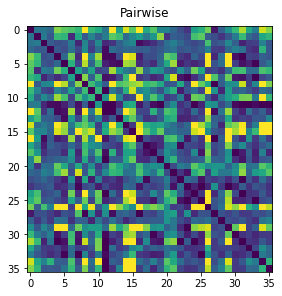

In [21]:
corr_obj = envelope_correlation(label_ts, orthogonalize='pairwise')
corr = corr_obj.combine()
corr = corr.get_data(output='dense')[:, :, 0]

def plot_corr(corr, title):
    fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
    ax.imshow(corr, cmap='viridis', clim=np.percentile(corr, [5, 95]))
    fig.suptitle(title)


plot_corr(corr, 'Pairwise')


# def plot_degree(corr, title):
#     threshold_prop = 0.15  # percentage of strongest edges to keep in the graph
#     degree = mne_connectivity.degree(corr, threshold_prop=threshold_prop)
#     stc = mne.labels_to_stc(labels, degree)
#     stc = stc.in_label(mne.Label(inv['src'][0]['vertno'], hemi='lh') +
#                        mne.Label(inv['src'][1]['vertno'], hemi='rh'))
#     return stc.plot(
#         clim=dict(kind='percent', lims=[75, 85, 95]), colormap='gnuplot',
#         subjects_dir=subjects_dir, views='dorsal', hemi='both',
#         smoothing_steps=25, time_label=title)


# brain = plot_degree(corr, 'Beta (pairwise, aparc_sub)')